In [1]:
import os
import re
import os.path as osp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import plotnine as pn
import warnings
from tcre.env import *
from tcre import lib
from ptkn import protein_tokenization as ptkn

# %run ../env.py
# %run ../src/lib.py
# %run src/protein_tokenization.py

In [2]:
df_tag = pd.read_csv(osp.join(DATA_DIR, 'articles', 'corpus', 'corpus_01', 'tags-union.csv'))
pd.set_option('display.max_info_rows', 10000000)
df_tag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2310512 entries, 0 to 2310511
Data columns (total 11 columns):
end_chr       2310512 non-null int64
end_wrd       2310512 non-null int64
ent_id        961277 non-null object
ent_lbl       961277 non-null object
ent_prefid    961277 non-null object
ent_src       2310512 non-null object
id            2310512 non-null object
start_chr     2310512 non-null int64
start_wrd     2310512 non-null int64
text          2310512 non-null object
type          2310512 non-null object
dtypes: int64(4), object(7)
memory usage: 193.9+ MB


In [3]:
df_tag['ent_src'].value_counts()

jnlpba    1349235
lkp        961277
Name: ent_src, dtype: int64

In [4]:
df_tag.head()

end_chr  end_wrd ent_id ent_lbl ent_prefid ent_src         id  start_chr  \
0      828      148    NaN     NaN        NaN  jnlpba  PMC100031        821   
1      957      170    NaN     NaN        NaN  jnlpba  PMC100031        912   
2     1012      181    NaN     NaN        NaN  jnlpba  PMC100031        991   
3     1375      239    NaN     NaN        NaN  jnlpba  PMC100031       1340   
4     1697      292    NaN     NaN        NaN  jnlpba  PMC100031       1684   

   start_wrd                                           text       type  
0        146                                        B cells  CELL_TYPE  
1        165  immunoglobulin M (IgM)-secreting spleen cells  CELL_TYPE  
2        178                          IgM-secreting B cells  CELL_TYPE  
3        236            non-parasite-directed B-cell clones  CELL_LINE  
4        288                                  B and T cells  CELL_TYPE

In [5]:
df_tag[df_tag['id'] == 'PMC5704053'].pipe(lambda df: df[df['text'] == 'TCM'])

end_chr  end_wrd              ent_id ent_lbl          ent_prefid  \
1727598     3299      596                 NaN     NaN                 NaN   
1727796     3299      596  CT6DE81C14BBB65271     TCM  CT143F3E7366C9650A   

        ent_src          id  start_chr  start_wrd text              type  
1727598  jnlpba  PMC5704053       3296        595  TCM         CELL_TYPE  
1727796     lkp  PMC5704053       3296        595  TCM  IMMUNE_CELL_TYPE

In [6]:
(df_tag['text'].str.contains('T') & (df_tag['ent_src'] == 'jnlpba')).value_counts()

False    1775014
True      535498
dtype: int64

In [7]:
df_tag[df_tag['ent_src'] == 'lkp']['type'].value_counts()

CYTOKINE                485040
IMMUNE_CELL_TYPE        314554
TRANSCRIPTION_FACTOR    161683
Name: type, dtype: int64

In [608]:
# NORM_REGEX = re.compile(r'(-cells|-cell| cells| cell|-lymphocytes|-lymphocyte| lymphocytes| lymphocyte)', flags=re.I)

# def normalize_noun_phrase(t):
#     return NORM_REGEX.sub('', t).strip()

In [38]:
import interlap

def get_paired_mentions(g):
    df1 = g[(g['ent_src'] == 'jnlpba') & (g['type'].isin(['CELL_TYPE', 'CELL_LINE']))]
    df2 = g[(g['ent_src'] == 'lkp') & (g['type'] == 'IMMUNE_CELL_TYPE')]
    
    rngs = interlap.InterLap()
    
    # Add jnlpba entries to interval lookup 
    for _, r in df1.iterrows():
        rngs.add((r['start_wrd'], r['end_wrd'], r))
        
    # Loop through direct matches, find jnlpba entries that overlap with first word,
    # and accumulate results which contain the records from both sources side-by-side
    df = []
    for i, r in df2.iterrows():
        matches = [
            o[-1][['id', 'start_wrd', 'end_wrd', 'type', 'text']].to_dict()
            for o in rngs.find((r.start_wrd, r.start_wrd))    
        ]
        for m in matches:
            # Add jnlpba row with extra data for corresponding lookup match
            df.append({**m, **{'match_prefid': r['ent_prefid'], 'match_lbl': r['ent_lbl'], 'match_text': r['text']}})
    return pd.DataFrame(df)
        
def get_cell_type_tags(df):
    res = []
    grps = df.groupby('id')
    for k, g in tqdm.tqdm(grps, total=len(grps)):
        res.append(get_paired_mentions(g))
    return pd.concat(res)
    

df_ct = (
    df_tag
    .pipe(lambda df: df[df['text'].str.contains('T')])
    #.pipe(lambda df: df[df['id'] == 'PMC5704053'])
    .pipe(get_cell_type_tags)
)
df_ct.info()

100%|██████████| 9392/9392 [06:20<00:00, 24.66it/s]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 178692 entries, 0 to 1
Data columns (total 8 columns):
end_wrd         178692 non-null int64
id              178692 non-null object
match_lbl       178692 non-null object
match_prefid    178692 non-null object
match_text      178692 non-null object
start_wrd       178692 non-null int64
text            178692 non-null object
type            178692 non-null object
dtypes: int64(2), object(6)
memory usage: 12.3+ MB


In [39]:
df_ct.head()

end_wrd         id match_lbl        match_prefid   match_text  start_wrd  \
0      252  PMC101751       Th1  CTC3A8C3CBC245616A          Th1        250   
0      111  PMC102037        Tc  CT231C4EC31B01615E  cytotoxic T        107   
0        6  PMC103809        Tc  CT231C4EC31B01615E  Cytotoxic T          3   
0       19  PMC103836        Th  CTB7DFCED683E6F0A9     T-Helper         12   
1       59  PMC103836        Th  CTB7DFCED683E6F0A9     T-helper         51   

                                       text       type  
0                                 Th1 cells  CELL_TYPE  
0      Gag-specific cytotoxic T lymphocytes  CELL_TYPE  
0                   Cytotoxic T Lymphocytes  CELL_TYPE  
0  Cytokine-Induced CD4+  T-Helper 1 (Th1)-  CELL_LINE  
1             T-helper 1 (Th1) or Th2 cells  CELL_TYPE

In [40]:
# Group by jnlpba span and aggregate all overlapping direct matches
df_ct_grp = df_ct.groupby(['id', 'start_wrd', 'end_wrd', 'text']).agg({'match_lbl': 'unique', 'match_text': 'unique'}).reset_index()
df_ct_grp.head()

id  start_wrd  end_wrd                                      text  \
0  PMC101751        250      252                                 Th1 cells   
1  PMC102037        107      111      Gag-specific cytotoxic T lymphocytes   
2  PMC103809          3        6                   Cytotoxic T Lymphocytes   
3  PMC103836         12       19  Cytokine-Induced CD4+  T-Helper 1 (Th1)-   
4  PMC103836         51       59             T-helper 1 (Th1) or Th2 cells   

        match_lbl            match_text  
0           [Th1]                 [Th1]  
1            [Tc]         [cytotoxic T]  
2            [Tc]         [Cytotoxic T]  
3            [Th]            [T-Helper]  
4  [Th, Th1, Th2]  [T-helper, Th1, Th2]

In [41]:
# Match count distribution (should all be > 0)
df_ct_grp['match_text'].apply(len).value_counts()

1    149855
2     10001
3      1395
4       605
5       127
6        42
7        20
8        10
9         2
Name: match_text, dtype: int64

In [43]:
df_ct_grp[df_ct_grp['match_text'].apply(len) == 1].head(3)

id  start_wrd  end_wrd                                  text  \
0  PMC101751        250      252                             Th1 cells   
1  PMC102037        107      111  Gag-specific cytotoxic T lymphocytes   
2  PMC103809          3        6               Cytotoxic T Lymphocytes   

  match_lbl     match_text  
0     [Th1]          [Th1]  
1      [Tc]  [cytotoxic T]  
2      [Tc]  [Cytotoxic T]

In [42]:
df_ct_grp[df_ct_grp['match_text'].apply(len) >= 8].head(3)

id  start_wrd  end_wrd  \
58251  PMC4309205       5427     5444   
65766  PMC4463688       1053     1075   
66161  PMC4475012       6847     6866   

                                                    text  \
58251  Th subtypes (Th1, Th2, Th17, Treg, Tfh, Th9, a...   
65766  Th1, Th2, Th17, Th9, Th22, follicular T (Tfh) ...   
66161  Th0, Th1, Th2, Th17, Tfh, Th9, iTreg and T reg...   

                                          match_lbl  \
58251    [Th, Th1, Th2, Th17, Treg, Tfh, Th9, Th22]   
65766        [Th1, Th2, Th17, Th9, Th22, Tfh, Treg]   
66161  [Th0, Th1, Th2, Th17, Tfh, Th9, iTreg, Treg]   

                                              match_text  
58251         [Th, Th1, Th2, Th17, Treg, Tfh, Th9, Th22]  
65766  [Th1, Th2, Th17, Th9, Th22, Tfh, regulatory T,...  
66161  [Th0, Th1, Th2, Th17, Tfh, Th9, iTreg, T regul...

## Mention Modality Frequencies

Investigate how often the following ways of expressing cell types occur:
1. Single named type mentions (e.g. CCR5+CD4+Foxp3+ **Treg cells**)
2. Unnamed type mentions (e.g. CCR5+CD4+Foxp3+ **T cells**)
3. Non-specific phenotypes (e.g. CCR5+CD4+Foxp3+ **cells**)


In [61]:
df_tag.head()

end_chr  end_wrd ent_id ent_lbl ent_prefid ent_src         id  start_chr  \
0      828      148    NaN     NaN        NaN  jnlpba  PMC100031        821   
1      957      170    NaN     NaN        NaN  jnlpba  PMC100031        912   
2     1012      181    NaN     NaN        NaN  jnlpba  PMC100031        991   
3     1375      239    NaN     NaN        NaN  jnlpba  PMC100031       1340   
4     1697      292    NaN     NaN        NaN  jnlpba  PMC100031       1684   

   start_wrd                                           text       type  
0        146                                        B cells  CELL_TYPE  
1        165  immunoglobulin M (IgM)-secreting spleen cells  CELL_TYPE  
2        178                          IgM-secreting B cells  CELL_TYPE  
3        236            non-parasite-directed B-cell clones  CELL_LINE  
4        288                                  B and T cells  CELL_TYPE

In [62]:
df_tag['type'].value_counts()

CELL_TYPE               1054510
CYTOKINE                 485040
IMMUNE_CELL_TYPE         314554
CELL_LINE                294725
TRANSCRIPTION_FACTOR     161683
Name: type, dtype: int64

In [ ]:
# df_pr_tkn.pipe(lambda df: df[df['match_ct_bin'] == 'none'])['text']\
#     .drop_duplicates().sample(n=250, random_state=1).values

In [517]:
df_mod = (
    df_tag
    .pipe(lambda df: df[df['text'].str.contains('T')])
    .pipe(lambda df: df[df['ent_src'] == 'jnlpba'])
    .pipe(lambda df: df[df['type'].isin(['CELL_TYPE', 'CELL_LINE'])])
)
df_mod['type'].value_counts()

CELL_TYPE    424797
CELL_LINE    110701
Name: type, dtype: int64

In [64]:
df_ct_grp.head()

id  start_wrd  end_wrd                                      text  \
0  PMC101751        250      252                                 Th1 cells   
1  PMC102037        107      111      Gag-specific cytotoxic T lymphocytes   
2  PMC103809          3        6                   Cytotoxic T Lymphocytes   
3  PMC103836         12       19  Cytokine-Induced CD4+  T-Helper 1 (Th1)-   
4  PMC103836         51       59             T-helper 1 (Th1) or Th2 cells   

        match_lbl            match_text  
0           [Th1]                 [Th1]  
1            [Tc]         [cytotoxic T]  
2            [Tc]         [Cytotoxic T]  
3            [Th]            [T-Helper]  
4  [Th, Th1, Th2]  [T-helper, Th1, Th2]

In [65]:
df_mod.head()

end_chr  end_wrd ent_id ent_lbl ent_prefid ent_src         id  start_chr  \
4      1697      292    NaN     NaN        NaN  jnlpba  PMC100031       1684   
10       18        4    NaN     NaN        NaN  jnlpba  PMC100064          0   
11      192       32    NaN     NaN        NaN  jnlpba  PMC100064        169   
12      909      148    NaN     NaN        NaN  jnlpba  PMC100064        891   
14     1256      202    NaN     NaN        NaN  jnlpba  PMC100064       1228   

    start_wrd                          text       type  
4         288                 B and T cells  CELL_TYPE  
10          0            CD4+ T Lymphocytes  CELL_TYPE  
11         29       MSP1a Carboxyl Terminus  CELL_LINE  
12        144            CD4+ T lymphocytes  CELL_TYPE  
14        198  T- and B-lymphocyte epitopes  CELL_TYPE

In [131]:
pd.Series(['CD8aACD8+']).str.count('CD[348][^0-9]')

0    2
dtype: int64

In [713]:
df_mod_jn = pd.merge(
    df_mod[['id', 'start_wrd', 'end_wrd', 'text', 'type', 'ent_src']],
    df_ct_grp[['id', 'start_wrd', 'end_wrd', 'match_lbl', 'match_text']].assign(match_ct=lambda df: df['match_lbl'].apply(len)),
    on=['id', 'start_wrd', 'end_wrd'],
    how='left'
)
df_mod_jn['match_ct'] = df_mod_jn['match_ct'].fillna(0).astype(int)
# TODO: can the protein tokenizer provide an efficient way to do this without full tokenization?
marker_prefix_regex = '(CD\d+|CCR\d+|CXCR\d+|IL\-\d+|TNF|TGF|IFN|FOXP3)'
df_mod_jn['marker_all_ct'] = df_mod_jn['text'].str.upper().str.count(marker_prefix_regex, flags=re.I)
df_mod_jn['marker_common_ct'] = df_mod_jn['text'].str.count('CD[348][^0-9]')
df_mod_jn['marker_ct'] = (df_mod_jn['marker_all_ct'] - df_mod_jn['marker_common_ct']).clip(0)

# Bin match and marker counts for convenience
def add_ct_bin(df, field):
    return pd.cut(df[field], bins=[0, 1, 2, np.inf], include_lowest=True, right=False, labels=['none', 'one', '2+'])
df_mod_jn = df_mod_jn.assign(match_ct_bin=lambda df: add_ct_bin(df, 'match_ct'))
df_mod_jn = df_mod_jn.assign(marker_ct_bin=lambda df: add_ct_bin(df, 'marker_ct'))

# Filter to where there is either a detected cell type within the span
# or the span matches a regex ensuring that the text has something to do
# with t cells
cell_type_regex = r' t[- ]?(?:cell|lymphocyte)'
mask = df_mod_jn['text'].str.contains(cell_type_regex, flags=re.I) | (df_mod_jn['match_ct'] > 0)
print('Len before applying cell type regex:', len(mask))
df_mod_jn = df_mod_jn[mask]

df_mod_jn.info()

Len before applying cell type regex: 535498
<class 'pandas.core.frame.DataFrame'>
Int64Index: 368603 entries, 0 to 535496
Data columns (total 14 columns):
id                  368603 non-null object
start_wrd           368603 non-null int64
end_wrd             368603 non-null int64
text                368603 non-null object
type                368603 non-null object
ent_src             368603 non-null object
match_lbl           162288 non-null object
match_text          162288 non-null object
match_ct            368603 non-null int64
marker_all_ct       368603 non-null int64
marker_common_ct    368603 non-null int64
marker_ct           368603 non-null int64
match_ct_bin        368603 non-null category
marker_ct_bin       368603 non-null category
dtypes: category(2), int64(6), object(6)
memory usage: 37.3+ MB


In [714]:
df_mod_jn[df_mod_jn['match_ct'] > 0].head()

id  start_wrd  end_wrd                                      text  \
18  PMC101751        250      252                                 Th1 cells   
19  PMC102037        107      111      Gag-specific cytotoxic T lymphocytes   
24  PMC103809          3        6                   Cytotoxic T Lymphocytes   
27  PMC103836         12       19  Cytokine-Induced CD4+  T-Helper 1 (Th1)-   
29  PMC103836         51       59             T-helper 1 (Th1) or Th2 cells   

         type ent_src       match_lbl            match_text  match_ct  \
18  CELL_TYPE  jnlpba           [Th1]                 [Th1]         1   
19  CELL_TYPE  jnlpba            [Tc]         [cytotoxic T]         1   
24  CELL_TYPE  jnlpba            [Tc]         [Cytotoxic T]         1   
27  CELL_LINE  jnlpba            [Th]            [T-Helper]         1   
29  CELL_TYPE  jnlpba  [Th, Th1, Th2]  [T-helper, Th1, Th2]         3   

    marker_all_ct  marker_common_ct  marker_ct match_ct_bin marker_ct_bin  
18              0                 0          0          one          none  
19              0                 0          0          one          none  
24              0                 0          0          one          none  
27              1                 1          0          one          none  
29              0                 0          0           2+          none

In [715]:
df_mod_jn.groupby(['match_ct_bin', 'marker_ct_bin']).size().unstack().fillna(0).astype(int)

marker_ct_bin    none    one    2+
match_ct_bin                      
none           183793  18476  4046
one            139318  10354  2843
2+               9331    233   209

In [716]:
df_mod_jn\
    .assign(match_ct_bin=add_match_ct_bin, marker_ct_bin=add_marker_ct_bin)\
    .pipe(lambda df: df[df['match_ct_bin'] == 'none'])\
    .pipe(lambda df: df[df['marker_ct_bin'] == '2+'])\
    .sample(10, random_state=1)

id  start_wrd  end_wrd  \
213308  PMC4368162       6318     6324   
500394  PMC6281225       2222     2229   
315249  PMC5095993       4243     4247   
44907   PMC2832688       3482     3488   
518391  PMC6392103       4585     4590   
85416   PMC3338602       3140     3143   
502437  PMC6290728       1145     1161   
173182  PMC4028236       4731     4736   
210286  PMC4349659       3376     3382   
424654  PMC5829452        405      412   

                                                             text       type  \
213308                                      CD45RA+ CD27+ T cells  CELL_TYPE   
500394       IFN-γ-producing and non-IFN-γ-producing CD4+ T cells  CELL_LINE   
315249                                    CD4+CD25−Foxp3+ T cells  CELL_TYPE   
44907                 IL-2+CD107a+IFN-γ+TNF-α+ CD8+ T cell subset  CELL_LINE   
518391                          inducible CD4+CD25−Foxp3+ T cells  CELL_LINE   
85416                                       CD44hiCD62Llo T cells  CELL_TYPE   
502437  CD4+, CD25, CD127CD3+, CD4+, CD25, Foxp3Suppressor T cell  CELL_TYPE   
173182                              CD44−CD62L+ naïve CD8 T cells  CELL_TYPE   
210286                                  CD40L+ IFNγ+ CD4+ T cells  CELL_TYPE   
424654                CD4+CD69+IL-10+ and CD8+CD69+IL-10+ T cells  CELL_TYPE   

       ent_src match_lbl match_text  match_ct  marker_all_ct  \
213308  jnlpba       NaN        NaN         0              2   
500394  jnlpba       NaN        NaN         0              3   
315249  jnlpba       NaN        NaN         0              3   
44907   jnlpba       NaN        NaN         0              5   
518391  jnlpba       NaN        NaN         0              3   
85416   jnlpba       NaN        NaN         0              2   
502437  jnlpba       NaN        NaN         0              7   
173182  jnlpba       NaN        NaN         0              3   
210286  jnlpba       NaN        NaN         0              3   
424654  jnlpba       NaN        NaN         0              6   

        marker_common_ct  marker_ct match_ct_bin marker_ct_bin  
213308                 0          2         none            2+  
500394                 1          2         none            2+  
315249                 1          2         none            2+  
44907                  1          4         none            2+  
518391                 1          2         none            2+  
85416                  0          2         none            2+  
502437                 3          4         none            2+  
173182                 1          2         none            2+  
210286                 1          2         none            2+  
424654                 2          4         none            2+

## Initialize Tokenizer

TODO:
- remove ["ifi", "dif", "esp"] synonyms
- add: CD8, Ly6, Ly6c, GFP, Thy1.1
- add: Foxp3, FoxP3, foxP3, foxp3
- add: CD45RO, CD57, PD1 (PD-1 is present)
- investigate: TC1 (CXCL7) cytokine since it overlaps with cell type
- investigate: TIL (toll like receptor 1) since it overlaps with cell type


In [541]:
# Symbols/synonyms to ignore (for all meta data sources)
bad_syns = ["ifi", "dif", "esp", "tc1", "til"]

In [569]:
df_pro = pd.read_csv(osp.join(META_DATA_DIR, 'raw', 'pro.raw.csv.gz'))

# Get groups and parents for CD molecules
tgt_ids = list(df_pro[df_pro['syn'].fillna('').str.startswith('CD')]['id'].unique())
tgt_ids = np.unique(list(df_pro.set_index('id').loc[tgt_ids]['parent'].unique()) + tgt_ids)
df_pro = (
    df_pro
    .pipe(lambda df: df[df['syn'].str.len() >= 3])
    .pipe(lambda df: df[(~df['syn'].str.contains(' ')) | (df['syn_typ'] == 'label')])
    .pipe(lambda df: df[df['id'].isin(tgt_ids)])
    # Remove synonyms like "hCFAP299/iso:h1"
    .pipe(lambda df: df[~df['syn'].str.contains('/|:')])
)

# Hack in manual entries for now
df_pro = df_pro.append(pd.DataFrame([
    {
    'category': 'organism-gene', 'id': 'PR:000001017', 'label': 'CD45RO', 
    'parent': 'PR:000001017', 'syn': 'CD45RO', 'syn_typ': 'label', 'species': 'any'
    },
    {
    'category': 'organism-gene', 'id': 'PR:000001084', 'label': 'CD8', 
    'parent': 'PR:000001084', 'syn': 'CD8', 'syn_typ': 'exact', 'species': 'any'
    },
    {
    'category': 'organism-gene', 'id': 'PRM:001', 'label': 'CD57', 
    'parent': 'PRM:001', 'syn': 'CD57', 'syn_typ': 'exact', 'species': 'any'
    },
    {
    'category': 'organism-gene', 'id': 'PR:000001919', 'label': 'PD1', 
    'parent': 'PR:000001919', 'syn': 'PD1', 'syn_typ': 'exact', 'species': 'any'
    },
]))

df_pro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4818 entries, 4874 to 3
Data columns (total 10 columns):
category      4818 non-null object
id            4818 non-null object
label         4818 non-null object
namespace     4814 non-null object
parent        575 non-null object
priority      4814 non-null float64
species       4818 non-null object
species_id    4814 non-null float64
syn           4818 non-null object
syn_typ       4818 non-null object
dtypes: float64(2), object(8)
memory usage: 414.0+ KB


In [574]:
df_pro.groupby('id').apply(lambda g: len(g[g['syn_typ'] == 'label'])).value_counts()

1    1229
0     112
dtype: int64

In [575]:
df_ck[df_ck['sym'].str.lower().isin(bad_syns)]

id  src  sym    lbl  spid    extid              prefid
2445  CK8263ED0D128A2F51  ckr  TC1  CXCL7     1   CID_51  CK06352AD1E10C88B6
2518  CKBA39EC0A931649EB  ckr  tc1  CXCL7     1   CID_51  CK06352AD1E10C88B6
3937  CKB48252402DDAF7FD  ckr  IFI  IFN-γ     1   CID_83  CKEF3883BE9F74024F
3957  CKCE1EE63C15FF125E  ckr  ifi  IFN-γ     1   CID_83  CKEF3883BE9F74024F
6275  CK819AE44B272C208A  ckr  esp   IL-5     1  CID_132  CK8128F0BCAA907933
6397  CK21B2072082A9C27B  ckr  dif   IL-6     1  CID_133  CKF8C95AB8BB638BAC
8151  CK1733B7581685A2BC  ckr  DIF  TNF-α     1  CID_174  CK34540B3AD7A90FCA

In [576]:
# Concatenate all transcription factor, cytokine, and protein entries into a single vocabulary for tokenizer
#pm_pro = df_pro[df_pro['syn_typ'] == 'label'].set_index('id')[['label']].to_dict(orient='index')

def get_preferred_label(g):
    g = g.assign(syn_len=g['syn'].str.len()).sort_values('syn_len')
    mask = g['syn'].str.contains('CD')
    # Use CD name if possible
    if mask.any():
        r = g[mask].iloc[0]
    # Use shortest possible synonym
    else:
        r = g.iloc[0]
    return dict(lbl=r['syn'], id=r['id'])

pm_pro = df_pro.groupby('id').apply(get_preferred_label).to_dict()
df_tf = lib.get_entity_meta_data(lib.TRANSCRIPTION_FACTORS)
pm_tf = df_tf.set_index('id')[['lbl']].to_dict(orient='index')
df_ck = lib.get_entity_meta_data(lib.CYTOKINES)
pm_ck = df_ck.set_index('id')[['lbl']].to_dict(orient='index')
vocab = {
    #**{r['syn']: (r['label'], r['id'], pm_pro.get(r['parent'], {}).get('label'), r['parent'], 'pr') for i, r in df_pro.iterrows()},
    **{r['syn']: (r['label'], r['id'], pm_pro.get(r['id'], {}).get('lbl'), pm_pro.get(r['id'], {}).get('id'), 'pr') for i, r in df_pro.iterrows()},
    **{r['sym']: (r['lbl'], r['id'], pm_tf.get(r['prefid'], {}).get('lbl'), r['prefid'], 'tf') for i, r in df_tf.iterrows()},
    **{r['sym']: (r['lbl'], r['id'], pm_ck.get(r['prefid'], {}).get('lbl'), r['prefid'], 'ck') for i, r in df_ck.iterrows()}
}
for syn in bad_syns:
    if syn in vocab:
        del vocab[syn]

In [577]:
len(vocab)

18506

In [634]:
tokenizer = ptkn.ProteinTokenizer(vocab)
#string = 'CD4+CD45RA+CD45RO-4-1BB-CD62L+++CCR7loCD127posCD27positiveCD28hiCD95+CD122+'
#string = 'CD8+Thy1.1+CD44hiLy6chiPSGL-1hiCD45RO+CD69-til-ifi-'

In [638]:
string = 'CD4brightCD45RAloCD45RO-4-1BB-CD62L+++'
for t in tokenizer.tokenize(string):
    print(f'{t.text:10} [term={t.token_text}, sign={t.sign_text}, value={t.sign_value}, preferred={t.metadata[2]}]')

CD4bright  [term=CD4, sign=bright, value=1, preferred=CD4]
CD45RAlo   [term=CD45RA, sign=lo, value=-1, preferred=CD45RA]
CD45RO-    [term=CD45RO, sign=-, value=-1, preferred=CD45RO]
4-1BB-     [term=4-1BB, sign=-, value=-1, preferred=CDw137]
CD62L+++   [term=CD62L, sign=+++, value=1, preferred=CD62L]


### Retokenize

First, make a case for how many spans reference some kind of T cell but don't have a recognizable name in the span:

In [615]:
# At this point, df_mod_jn contains all tags that at least have something to do with T cells based on
# either having a known T cell type substring (Th1) or matching the generic regex r' t[- ]?(?:cell|lymphocyte)'

In [717]:
# Number of unique phrases (case-insensitive):
df_mod_jn.assign(text=lambda df: df['text'].str.lower().str.strip())['text'].nunique()

70813

In [718]:
# Num unique phrases by match count bin
df_mod_jn.assign(text=lambda df: df['text'].str.lower().str.strip())\
    .groupby('match_ct_bin')['text'].nunique().fillna(0).astype(int)

match_ct_bin
none    43901
one     23116
2+       3826
Name: text, dtype: int64

In [754]:
def add_percentage(df):
    col_name = df.columns.name
    return (
        pd.concat([
                df.rename(columns=lambda c: ('count', c)),
                (100 * df / df.sum().sum()).round(2).rename(columns=lambda c: ('percent', c))
            ], axis=1
        ).pipe(lambda df: df.set_axis(
            pd.MultiIndex.from_tuples(df.columns, names=['', col_name]), axis=1
        , inplace=False))
    )

In [755]:
# Num unique phrases by bin
df_mod_jn.assign(text=lambda df: df['text'].str.lower().str.strip())\
    .groupby(['match_ct_bin', 'marker_ct_bin'])['text'].nunique().unstack().fillna(0).astype(int)\
    .pipe(add_percentage)

count             percent             
marker_ct_bin   none   one    2+    none    one    2+
match_ct_bin                                         
none           33847  7365  2705   47.77  10.39  3.82
one            17102  4134  1880   24.14   5.83  2.65
2+              3447   205   174    4.86   0.29  0.25

In [756]:
df_mod_jn.groupby(['match_ct_bin', 'marker_ct_bin']).size().unstack().fillna(0).astype(int)\
    .pipe(add_percentage)

count              percent            
marker_ct_bin    none    one    2+    none   one    2+
match_ct_bin                                          
none           183793  18476  4046   49.86  5.01  1.10
one            139318  10354  2843   37.80  2.81  0.77
2+               9331    233   209    2.53  0.06  0.06

In [733]:
# Examples for each combo above:
df_mod_jn.groupby(['match_ct_bin', 'marker_ct_bin'], group_keys=False).apply(lambda g: g.sample(3, random_state=1))\
    [['match_ct_bin', 'marker_ct_bin', 'text']]\
    .sort_values(['match_ct_bin', 'marker_ct_bin'])

match_ct_bin marker_ct_bin  \
428228         none          none   
174177         none          none   
310132         none          none   
257008         none           one   
321938         none           one   
86538          none           one   
213308         none            2+   
500394         none            2+   
315249         none            2+   
132237          one          none   
273741          one          none   
172472          one          none   
512606          one           one   
484879          one           one   
47649           one           one   
370908          one            2+   
240134          one            2+   
447495          one            2+   
258925           2+          none   
134671           2+          none   
390941           2+          none   
511408           2+           one   
181523           2+           one   
388185           2+           one   
151624           2+            2+   
475592           2+            2+   
194966           2+            2+   

                                                                                                                        text  
428228                                                                                                  CD3+CD8- CD4 T cells  
174177                                                                                              WT effector CD4+ T cells  
310132                                                                                                           CD4 T cells  
257008                                                                                         CD27low effector CD4+ T cells  
321938                                                                                                         IL-10+ T cell  
86538                                                                                                   dermal CCR8+ T cells  
213308                                                                                                 CD45RA+ CD27+ T cells  
500394                                                                  IFN-γ-producing and non-IFN-γ-producing CD4+ T cells  
315249                                                                                               CD4+CD25−Foxp3+ T cells  
132237                                                                                       effector/central memory T cells  
273741                                                                                             circulating naive T cells  
172472                                                                                                    regulatory T cells  
512606                                                                                               TNF-α-treated Th9 cells  
484879                                                                                                           CD39- Tregs  
47649                                                                                                  CD4+CD25+ T reg cells  
370908                                                                                         CD4+CD25HighCD127- Treg cells  
240134                                                                                                CD4+CD25hiFOXP3+ Tregs  
447495                                                                           human CD45RAloCD45ROhi activated Treg cells  
258925                                                                                                              Th17 and  
134671                                                                                                  Th1 and Th17 cells\n  
390941                                                                                                    Th1 and Th17 cells  
511408                                                                           Foxp3+ Tregs and T regulatory 1 (Tr1) cells  
181523                                           

In [629]:
df_pr_tkn = df_mod_jn.pipe(lambda df: df[(df['marker_ct'] >= 1) & (df['match_ct'] <= 1)]).copy()
df_pr_tkn['row_id'] = np.arange(len(df_pr_tkn))
df_pr_tkn.groupby(['match_ct_bin', 'marker_ct_bin']).size().unstack().fillna(0).astype(int)

marker_ct_bin    one    2+
match_ct_bin              
none           17740  3029
one             8212  1468

In [582]:
# Show fairly large sample of spans with no recognizable type to be sure there aren't 
# any sneaking in that aren't related to t cells
df_pr_tkn[df_pr_tkn['match_ct_bin'] == 'none']['text'].sample(n=100, random_state=1).values

array(['IL-13+ T cells', 'IL-17+FoxP3+ T cells',
       'CD4+CCR6+IL-17+ T cells', 'CD19.CAR T-cells',
       'IL-17 producing T cells', 'memory CD4+CD44+CD25−CD62Llow T cells',
       'E7-specific CD8+/IFN-γ+ double-positive T cells',
       'CD44hi CD8+ T cells', 'IL-17-producing T cells',
       'CD4+CD25+ T cells', 'CD44hi CD8 T cells', 'CD4+CD25− T cells',
       'CD4+CD25− T cells', 'Il-23r-deficient T cells',
       'PB white CD3+IFNγ+ T cells', 'CD4+CD44hi T cells',
       'CD4+CD25− T cells', 'CD46-activated T cells',
       'CXCR5+CD8+ T cells', 'CD161-expressing CD4+ and CD8+ T cells',
       'CD4CD8 DP T cells', 'FOXP3+CD25+ T cells',
       'IFN-γ double positive α/β T cells', 'CXCR5+ T cells',
       'IFNγ-expressing CD4 T-cells', 'CD62Llo effector T cells',
       'memory CD4+ CD45RO+ T cells', 'Bcl-3TOE CD4+CD25− T cells',
       'CD4CD8 double positive T cells', 'IL-4–producing T cells',
       'effector senescent CD8+CD57+ T-cells',
       'IL-17A IFNγ-double positive

In [583]:
len(df_pr_tkn)

30449

Now retokenize to get a better sense for what markers are included in the spans with no specific type name:

In [599]:
def get_proteins(r):
    return [
        t
        for w in re.split(r'\s+', r['text'])
        for t in tokenizer.tokenize(w)
        if t.metadata is not None
    ]

df_pr_tkn['prs'] = [get_proteins(r) for _, r in tqdm.tqdm(df_pr_tkn.iterrows(), total=len(df_pr_tkn))]

In [585]:
df_pr_tkn.sample(15, random_state=3).drop(['marker_common_ct', 'marker_all_ct'], axis=1)

id  start_wrd  end_wrd                                 text  \
113989  PMC3561630       4005     4011                CD4+ CD25+ Treg cells   
246589  PMC4586578       4420     4423              IFN-γ-producing T cells   
349174  PMC5389357       2361     2366  human IL-10-induced Tr1 cell clones   
224248  PMC4439128       6002     6006  IL-4-producing CD44hiCD62L- T cells   
377499  PMC5566564       5659     5664             Th17 (CD4+IL-17A+) cells   
349024  PMC5388800       4270     4273          senescent CD4+CD28- T-cells   
445866  PMC5965901       4277     4280                      γδIFN-γ T cells   
31966   PMC2638842       6366     6369                   CD8+CD127− T cells   
402927  PMC5719008          0        4               Human CD26high T cells   
389786  PMC5638602       1197     1200          anti-IL-4-treated Th2 cells   
305359  PMC5028705       6028     6031                    CD4+CD25− T cells   
445195    PMC59583       2991     2996                   CD8+ CD28- T cells   
210154  PMC4349492       1099     1104          CD4+CD25+ regulatory T cell   
65575   PMC3120670        344      348       T helper IL-17-producing cells   
372379  PMC5533788       3961     3965                        CD28+ T cells   

             type ent_src match_lbl      match_text  match_ct  marker_ct  \
113989  CELL_TYPE  jnlpba    [Treg]          [Treg]         1          1   
246589  CELL_LINE  jnlpba       NaN             NaN         0          1   
349174  CELL_LINE  jnlpba   [Treg1]           [Tr1]         1          1   
224248  CELL_LINE  jnlpba       NaN             NaN         0          3   
377499  CELL_LINE  jnlpba    [Th17]          [Th17]         1          1   
349024  CELL_TYPE  jnlpba       NaN             NaN         0          1   
445866  CELL_LINE  jnlpba       NaN             NaN         0          1   
31966   CELL_TYPE  jnlpba       NaN             NaN         0          1   
402927  CELL_TYPE  jnlpba       NaN             NaN         0          1   
389786  CELL_LINE  jnlpba     [Th2]           [Th2]         1          1   
305359  CELL_TYPE  jnlpba       NaN             NaN         0          1   
445195  CELL_TYPE  jnlpba       NaN             NaN         0          1   
210154  CELL_LINE  jnlpba    [Treg]  [regulatory T]         1          1   
65575   CELL_TYPE  jnlpba      [Th]      [T helper]         1          1   
372379  CELL_TYPE  jnlpba       NaN             NaN         0          1   

       match_ct_bin marker_ct_bin  row_id                               prs  
113989          one           one    7907               [CD4⁺(+), CD25⁺(+)]  
246589         none           one   14966                       [IFN-γ⁻(-)]  
349174          one           one   20744                       [IL-10⁻(-)]  
224248         none            2+   13752  [IL-4⁻(-), CD44⁺(hi), CD62L⁻(-)]  
377499          one           one   22209             [CD4⁺(+), IL-17A⁺(+)]  
349024         none           one   20708               [CD4⁺(+), CD28⁻(-)]  
445866         none           one   26084                           [IFN-γ]  
31966          none           one    2229              [CD8⁺(+), CD127⁻(−)]  
402927         none           one   23653                     [CD26⁺(high)]  
389786          one           one   22861                        [IL-4⁻(-)]  
305359         none           one   18192               [CD4⁺(+), CD25⁻(−)]  
445195         none           one   26028               [CD8⁺(+), CD28⁻(-)]  
210154          one           one   12595               [CD4⁺(+), CD25⁺(+)]  
65575           one           one    4835                       [IL-17⁻(-)]  
372379         none           one   21976                        [CD28⁺(+)]

In [586]:
df_pr_tkn['prs'].apply(len).value_counts()

2     15228
1     10639
3      3300
4       854
5       168
0       116
6        89
7        21
8        19
10        5
9         4
11        3
12        2
13        1
Name: prs, dtype: int64

In [587]:
pd.set_option('display.max_colwidth', 120)
df_pr_tkn[df_pr_tkn['prs'].apply(len) == 8]['text'].head(25)

87218                                                              CD4+LIR-1+ or CD8+LIR-1+ T and CD4+LIR-1+ or CD8+CD57+ T cells
109085                                                          CD161−CD4+, CD161+CD4+, CD161neg/lowCD8+, and CD161hiCD8+ T cells
124169                                CD4+ or CD8+ CD62LhighCD44low (B, C), CD62LhighCD44high (D, E) and CD62LlowCD44high T cells
134442    T central memory (TCM) CD28+CCR7+; transitional effector memory (TEM1) CD28+CCR7- and fully differentiated effector ...
164380                                naïve (CD45RA+ CD27+) and memory (CD45RA− CD27+) CD4 (CD3+ CD4+) or CD8 (CD3+ CD4−) T cells
164471                                naïve (CD45RA+ CD27+) and memory (CD45RA− CD27+) CD4 (CD3+ CD4+) or CD8 (CD3+ CD4−) T cells
239232                            naive and memory CD4+ (CD44lowCD62Lhigh, CD44highCD62Llow) and CD8+ (CD44low, CD44high) T cells
264215                                                                   CD4+CD25+, CD4+CD

In [588]:
t = df_pr_tkn['prs'].iloc[0][0]
t.metadata, t.text, t.sign_value

(('CD14 molecule', 'PR:000001889', 'CD14', 'PR:000001889', 'pr'), 'CD14', 0)

In [589]:
df_pr_flt = pd.DataFrame([
    dict(
        row_id=r['row_id'], doc_id=r['id'], start_wrd=r['start_wrd'], end_wrd=r['end_wrd'], 
        text=r['text'], match_lbl=r['match_lbl'], match_ct=r['match_ct'],
        pr_lbl=t.metadata[0], pr_id=t.metadata[1], pr_preflbl=t.metadata[2], 
        pr_prefid=t.metadata[3], pr_typ=t.metadata[4], pr_sign=t.sign_value
    )
    for i, r in df_pr_tkn.iterrows()
    for t in r['prs']
])

# Ensure that the associated cell type lists are either empty or have one item (and then extract single items)
assert df_pr_flt['match_lbl'].apply(lambda v: len([] if pd.isnull(v) else v)).isin([0, 1]).all()
df_pr_flt['match_lbl'] = df_pr_flt['match_lbl'].apply(lambda v: None if pd.isnull(v) else v[0])

df_pr_flt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56240 entries, 0 to 56239
Data columns (total 13 columns):
doc_id        56240 non-null object
end_wrd       56240 non-null int64
match_ct      56240 non-null int64
match_lbl     16252 non-null object
pr_id         56240 non-null object
pr_lbl        56240 non-null object
pr_prefid     56240 non-null object
pr_preflbl    56240 non-null object
pr_sign       56240 non-null int64
pr_typ        56240 non-null object
row_id        56240 non-null int64
start_wrd     56240 non-null int64
text          56240 non-null object
dtypes: int64(5), object(8)
memory usage: 5.6+ MB


In [590]:
df_pr_flt.head()

doc_id  end_wrd  match_ct match_lbl               pr_id         pr_lbl  \
0   PMC101674      177         0      None        PR:000001889  CD14 molecule   
1   PMC104529      170         0      None        PR:000001343  CD69 molecule   
2   PMC104529      170         0      None  CK216B03A5814616B8            CD4   
3   PMC104529      170         0      None        PR:000001084            CD8   
4  PMC1555646       80         0      None  CK216B03A5814616B8            CD4   

            pr_prefid pr_preflbl  pr_sign pr_typ  row_id  start_wrd  \
0        PR:000001889       CD14        0     pr       0        171   
1        PR:000001343       CD69        0     pr       1        164   
2  CK216B03A5814616B8        CD4        0     ck       1        164   
3        PR:000001084        CD8        0     pr       1        164   
4  CK216B03A5814616B8        CD4        1     ck       2         77   

                                      text  
0                  CD14 positive), T cells  
1  CD69-positive CD4 and CD8 T lymphocytes  
2  CD69-positive CD4 and CD8 T lymphocytes  
3  CD69-positive CD4 and CD8 T lymphocytes  
4    CD4+CD45RO+Foxp3+CD25hi T lymphocytes

In [591]:
df_pr_flt['pr_typ'].value_counts()

ck    38480
pr    17286
tf      474
Name: pr_typ, dtype: int64

In [592]:
assert df_pr_flt['match_ct'].isin([0, 1]).all()
df_pr_flt['match_ct'].value_counts()

0    39988
1    16252
Name: match_ct, dtype: int64

In [593]:
df_pr_flt['match_lbl'].unique()

array([None, 'Treg', 'Th1', 'Th2', 'TMEM', 'TN', 'nTreg', 'Th17', 'TCM',
       'Th', 'NKT', 'γδT', 'Tc1', 'TEM', 'ThP', 'Thymocyte', 'Tc',
       'Treg1', 'iTreg', 'TEMRA', 'pTreg', 'Tfh', 'Th22', 'γδT-Vγ9Vδ2',
       'γδT-Vγ4', 'Th0', 'Tc17', 'Th3', 'Tscm', 'Treg17', 'Th9', 'MAIT',
       'Trm', 'Tfreg', 'γδT-Vδ2', 'Tc2', 'γδT-Vδ1', 'Tc9', 'γδT-17',
       'Tfh17like'], dtype=object)

In [594]:
# df_ct_cts[df_ct_cts['match_lbl'] == 'Tc17'].head(15)

In [595]:
# for t in tokenizer.tokenize('CD45RO+'):
#     print(t.text, t.sign_value, t.metadata)

In [596]:
df_pr_flt[(df_pr_flt['match_lbl'] == 'TCM') & (df_pr_flt['pr_lbl'] == 'CCR7')]['pr_sign'].value_counts()#.sample(10, random_state=1)

 1    36
-1     6
Name: pr_sign, dtype: int64

In [597]:
#df_pr_flt.pipe(lambda df: df[(df['match_lbl'] == 'Trm') & (df['pr_preflbl'] == 'CD103') & (df['pr_sign'] == -1)])

#### Visualize co-occurrence of proteins and cell types (when both in same span)

In [631]:
target_cell_types = [
    'Treg', 'Th1', 'Th2', 'TMEM', 'TN', 'Th17', 'TCM',
    'Th', 'NKT', 'γδT', 'TEM', 'Treg1',
    'iTreg', 'TEMRA', 'Tfh', 'Th22',
    'Th0', 'Tscm', 'Th9', 'MAIT', 'Trm'
]

warnings.filterwarnings('ignore', category=FutureWarning)
p = (
    pn.ggplot(
        df_pr_flt
        .pipe(lambda df: df[df['match_lbl'].notnull()])
        .pipe(lambda df: df[df['match_lbl'].notnull()])
        .pipe(lambda df: df[df['match_lbl'].isin(target_cell_types)])
        # Resolve protein names to parent, where possible
        .assign(pr_lbl=lambda df: np.where(df['pr_preflbl'].notnull(), df['pr_preflbl'], df['pr_lbl']))
        .assign(pr_sign=lambda df: df['pr_sign'].map({0: 'neutral', 1: 'positive', -1: 'negative'}))
        .groupby(['match_lbl', 'pr_lbl', 'pr_sign']).size().rename('count').reset_index()
        .groupby('match_lbl', group_keys=False).apply(lambda g: g[
            g['pr_lbl'].isin(g.groupby('pr_lbl')['count'].sum().sort_values().tail(10).index.values)
        ])
        .assign(text=lambda df: df['count'].apply(lambda v: str(v) if v > 1 else ''))
        ,
        pn.aes(x='pr_lbl', y='count', fill='pr_sign', label='text')
    ) + 
    pn.geom_bar(stat='identity', alpha=.3, position='stack') + 
    pn.geom_text(position=pn.position_stack(vjust = 0.5)) +
    pn.facet_wrap('~match_lbl', scales='free', ncol=3) +
    pn.scale_y_log10() +
    pn.coord_flip() +
    pn.theme_bw() + 
    pn.theme(figure_size=(24, 32))
)

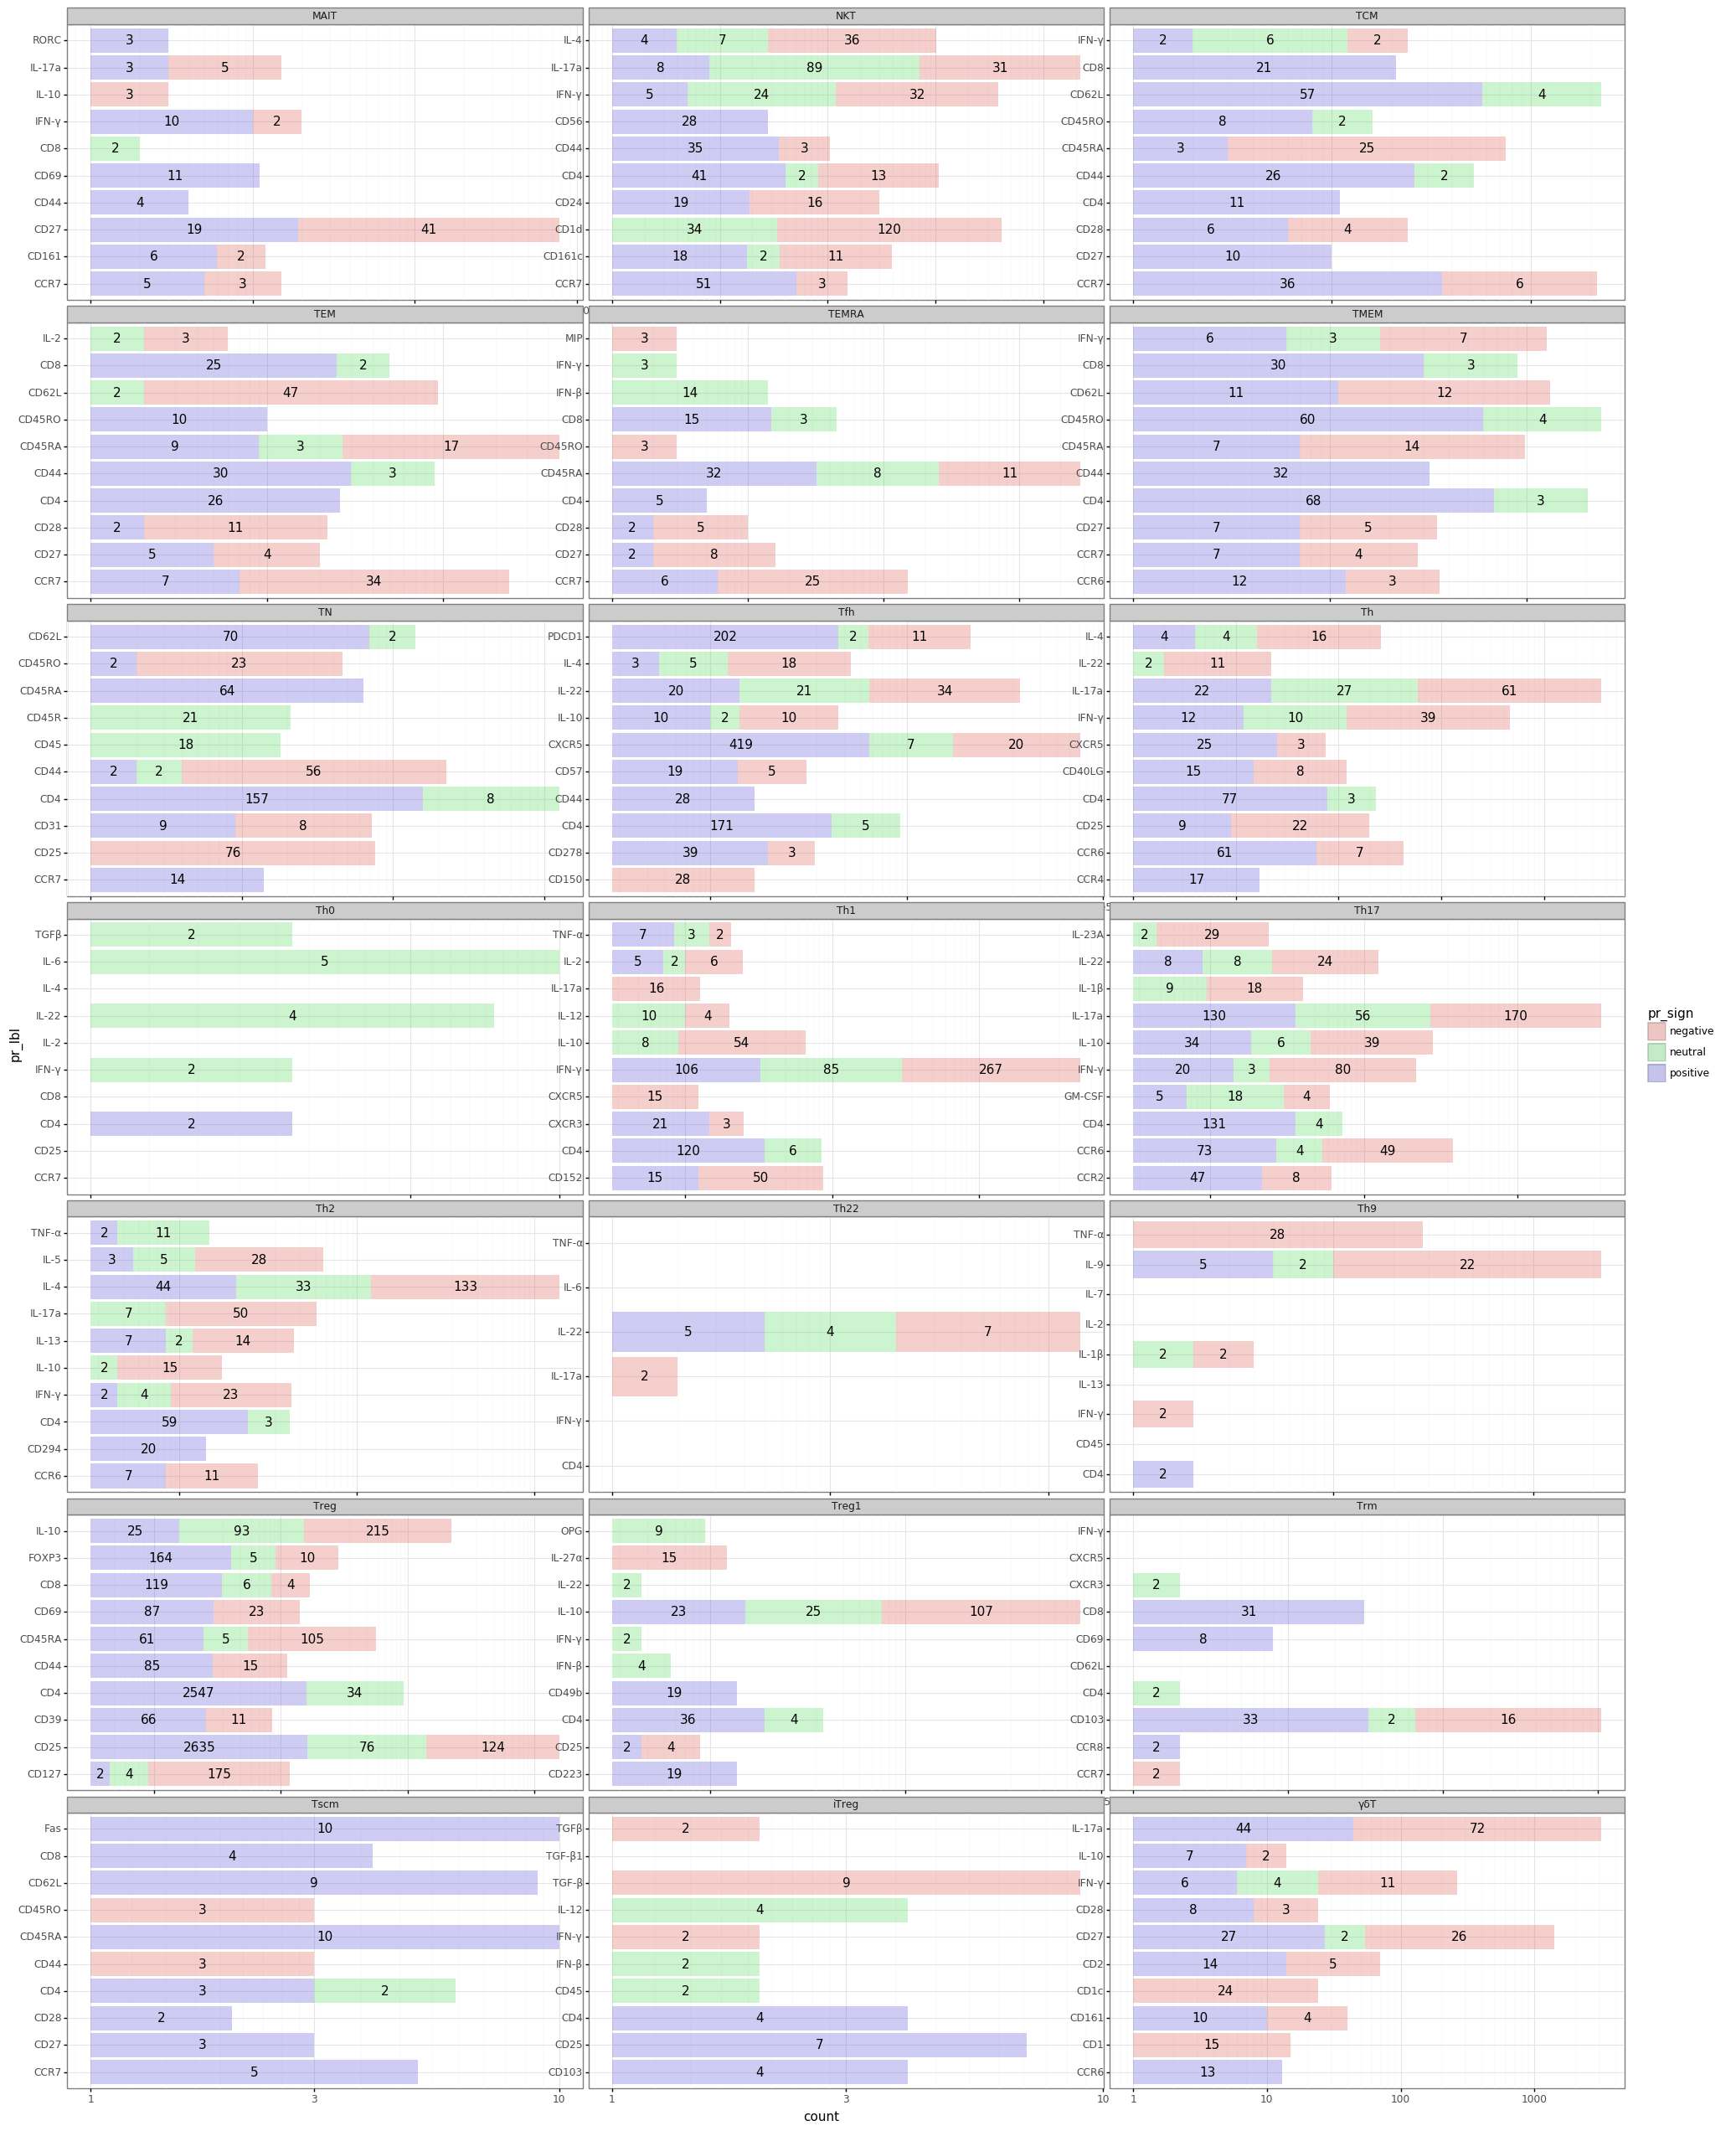

<ggplot: (8776760038064)>

In [632]:
p

#### Visualize phenotype distribution with and without known cell types

In [600]:
assert df_pr_flt['match_ct'].isin([0, 1]).all()

target_cell_types = [
    'Treg', 'Th1', 'Th2', 'TMEM', 'TN', 'Th17', 'TCM',
    'Th', 'NKT', 'γδT', 'TEM', 'Treg1',
    'iTreg', 'TEMRA', 'Tfh', 'Th22',
    'Th0', 'Tscm', 'Th9', 'MAIT', 'Trm'
]

# Restrict stacked protein data frame to only original records where there are 
# at least 2 non-common references (e.g. CD4, CD8)
def accept(r):
    prs = r['prs']
    prs = [p for p in prs if p.token_text not in ['CD4', 'CD8', 'CD8', 'ifi', 'dif']]
    return len(prs) >= 2
df_viz = df_pr_flt[df_pr_flt['row_id'].isin(df_pr_tkn[df_pr_tkn.apply(accept, axis=1)]['row_id'].unique())].copy()

unk_cell_type_max_rows = 10000
common_protein_max = 50

# Sample a set number of rows with no cell type and all rows with a cell type
row_ids = pd.Series(df_viz[df_viz['match_lbl'].isnull()]['row_id'].unique())
row_ids = (
    list(df_viz[df_viz['match_lbl'].notnull()]['row_id'].unique()) + 
    row_ids.sample(min(unk_cell_type_max_rows, len(row_ids)), random_state=1).tolist()
)

def aggfunc(v):
    # Map signs to {+: 2, neutral: 1, -: -1, na: 0}
    if len(v) > 1:
        raise ValueError(str(v))
    return {1: 2, 0: 1, -1: -1}[v.iloc[0]]

def remove_dup_prs(df):
    cts = df.groupby(['row_id', 'pr_lbl']).size().rename('count').reset_index()
    return df[~df['row_id'].isin(cts[cts['count'] >= 2]['row_id'].unique())]

df_embed = (
    df_viz
    .pipe(lambda df: df[df['row_id'].isin(row_ids)])
    # Re-assign label to preferred (shorter) label if possible
    .assign(pr_lbl=lambda df: np.where(df['pr_preflbl'].notnull(), df['pr_preflbl'], df['pr_lbl']))
    # Eliminate rows with multiple references to same protein (e.g. "CD4+ and CD4- cells")
    .pipe(remove_dup_prs)
    # Fill in cell type string with default value (after filtering to target types)
    .pipe(lambda df: df[df['match_lbl'].isin(target_cell_types) | df['match_lbl'].isnull()])
    .assign(match_lbl=lambda df: df['match_lbl'].fillna('NONE'))
    
    # Restrict to n most common proteins
    #.pipe(lambda df: df[df['pr_lbl'].isin(df['pr_lbl'].value_counts().sort_values().tail(common_protein_max).index.values)])
    
    # Pivot to protein indicator matrix for each row
    .assign(ind=1)
    .pivot_table(index=['doc_id', 'row_id', 'match_lbl', 'text'], columns=['pr_lbl'], values='pr_sign', aggfunc=aggfunc)
    .fillna(0)
)
df_embed.head()

pr_lbl                                                             Apo3  BCL6  \
doc_id     row_id match_lbl text                                                
PMC1323501 24     NONE      CD44hi and IFN-γ+ CD8+ T cells          0.0   0.0   
PMC151668  40     NONE      IL-2- or IFNγ-producing T cells         0.0   0.0   
           45     NONE      IL-4- or IFNγ-producing T cells         0.0   0.0   
           47     NONE      IL-4- and IFNγ-producing T cells        0.0   0.0   
PMC1555646 2      NONE      CD4+CD45RO+Foxp3+CD25hi T lymphocytes   0.0   0.0   

pr_lbl                                                             CCL11  \
doc_id     row_id match_lbl text                                           
PMC1323501 24     NONE      CD44hi and IFN-γ+ CD8+ T cells           0.0   
PMC151668  40     NONE      IL-2- or IFNγ-producing T cells          0.0   
           45     NONE      IL-4- or IFNγ-producing T cells          0.0   
           47     NONE      IL-4- and IFNγ-producing T cells         0.0   
PMC1555646 2      NONE      CD4+CD45RO+Foxp3+CD25hi T lymphocytes    0.0   

pr_lbl                                                             CCL16  \
doc_id     row_id match_lbl text                                           
PMC1323501 24     NONE      CD44hi and IFN-γ+ CD8+ T cells           0.0   
PMC151668  40     NONE      IL-2- or IFNγ-producing T cells          0.0   
           45     NONE      IL-4- or IFNγ-producing T cells          0.0   
           47     NONE      IL-4- and IFNγ-producing T cells         0.0   
PMC1555646 2      NONE      CD4+CD45RO+Foxp3+CD25hi T lymphocytes    0.0   

pr_lbl                                                             CCL22  \
doc_id     row_id match_lbl text                                           
PMC1323501 24     NONE      CD44hi and IFN-γ+ CD8+ T cells           0.0   
PMC151668  40     NONE      IL-2- or IFNγ-producing T cells          0.0   
           45     NONE      IL-4- or IFNγ-producing T cells          0.0   
           47     NONE      IL-4- and IFNγ-producing T cells         0.0   
PMC1555646 2      NONE      CD4+CD45RO+Foxp3+CD25hi T lymphocytes    0.0   

pr_lbl                                                             CCL25  \
doc_id     row_id match_lbl text                                           
PMC1323501 24     NONE      CD44hi and IFN-γ+ CD8+ T cells           0.0   
PMC151668  40     NONE      IL-2- or IFNγ-producing T cells          0.0   
           45     NONE      IL-4- or IFNγ-producing T cells          0.0   
           47     NONE      IL-4- and IFNγ-producing T cells         0.0   
PMC1555646 2      NONE      CD4+CD45RO+Foxp3+CD25hi T lymphocytes    0.0   

pr_lbl                                                             CCL6  \
doc_id     row_id match_lbl text                                          
PMC1323501 24     NONE      CD44hi and IFN-γ+ CD8+ T cells          0.0   
PMC151668  40     NONE      IL-2- or IFNγ-producing T cells         0.0   
           45     NONE      IL-4- or IFNγ-producing T cells         0.0   
           47     NONE      IL-4- and IFNγ-producing T cells        0.0   
PMC1555646 2      NONE      CD4+CD45RO+Foxp3+CD25hi T lymphocytes   0.0   

pr_lbl                                                             CCR10  \
doc_id     row_id match_lbl text                                           
PMC1323501 24     NONE      CD44hi and IFN-γ+ CD8+ T cells           0.0   
PMC151668  40     NONE      IL-2- or IFNγ-producing T cells          0.0   
           45     NONE      IL-4- or IFNγ-producing T cells          0.0   
           47     NONE      IL-4- and IFNγ-producing T cells         0.0   
PMC1555646 2      NONE      CD4+CD45RO+Foxp3+CD25hi T lymphocytes    0.0   

pr_lbl                                                             CCR2  CCR4  \
doc_id     row_id match_lbl text                                                
PMC1323501 24     NONE      CD44hi and IFN-γ+ CD8+ T cells          0.0   0.0  

In [601]:
df_embed.shape

(4854, 210)

In [602]:
df_embed.stack().value_counts()

 0.0    1005759
 2.0       8748
-1.0       3436
 1.0       1397
dtype: int64

In [701]:
import umap
from numba import NumbaPerformanceWarning, NumbaWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)
    warnings.filterwarnings("ignore", category=NumbaWarning)
    Y = umap.UMAP(metric='manhattan', min_dist=.5).fit_transform(df_embed.values)
Y.shape

/opt/conda/envs/nlp/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 12 separate connected components using meta-embedding (experimental)



(4854, 2)

In [604]:
import plotly
import plotly.plotly as py
from plotly import graph_objs as go
plotly.offline.init_notebook_mode()

In [702]:
df_embed.reset_index()['match_lbl'].unique()

array(['NONE', 'TMEM', 'Treg', 'TN', 'Th', 'Th2', 'Th1', 'NKT', 'Th17',
       'Tfh', 'TEM', 'γδT', 'TCM', 'Th0', 'Treg1', 'TEMRA', 'Tscm',
       'Th22', 'iTreg', 'MAIT', 'Trm', 'Th9'], dtype=object)

In [703]:
df_umap = pd.DataFrame(Y, index=df_embed.index).add_prefix('X')
primary_cell_types = ['Treg', 'Trm', 'Tscm', 'NKT', 'Th1', 'Th2', 'Th17', 'Tfh', 'NONE']

def get_pr_list(r):
    prs = ['{}{}'.format(pr, {-1: '⁻', 1: '', 2: '⁺'}[v]) for pr, v in r[r != 0].to_dict().items()]
    return ' '.join(sorted(prs))
df_umap['pr_list'] = df_embed.apply(get_pr_list, axis=1)
df_umap['pr_len'] = df_embed.apply(lambda r: (r!=0).sum(), axis=1)
df_umap = df_umap.reset_index()
#df_umap['match_lbl'] = df_umap['match_lbl'].apply(lambda v: v if v in primary_cell_types else 'OTHER')
df_umap.head()

doc_id  row_id match_lbl                                   text  \
0  PMC1323501      24      NONE         CD44hi and IFN-γ+ CD8+ T cells   
1   PMC151668      40      NONE        IL-2- or IFNγ-producing T cells   
2   PMC151668      45      NONE        IL-4- or IFNγ-producing T cells   
3   PMC151668      47      NONE       IL-4- and IFNγ-producing T cells   
4  PMC1555646       2      NONE  CD4+CD45RO+Foxp3+CD25hi T lymphocytes   

          X0         X1             pr_list  pr_len  
0  -9.302813  -6.032842   CD44⁺ CD8⁺ IFN-γ⁺       3  
1  -2.544324  -2.913935        IFN-γ⁻ IL-2⁻       2  
2  -2.126595  -3.605157        IFN-γ⁻ IL-4⁻       2  
3  -2.095431  -3.283938        IFN-γ⁻ IL-4⁻       2  
4  22.817141  15.790405  CD25⁺ CD45RO⁺ CD4⁺       3

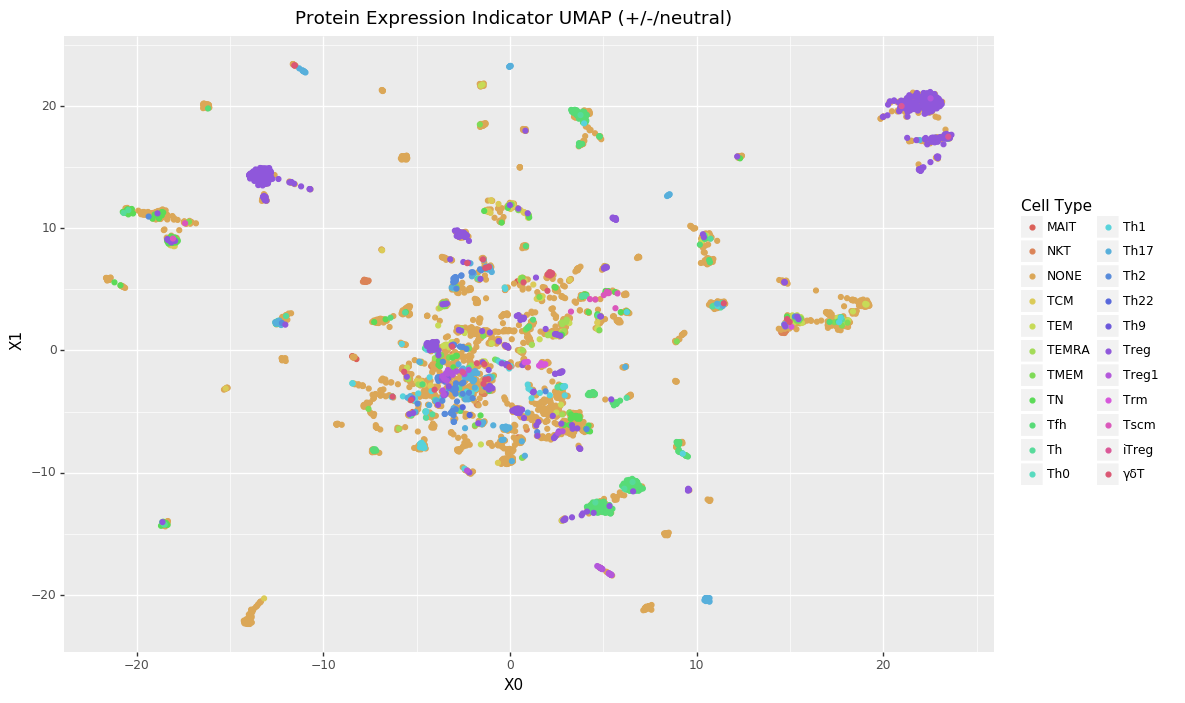

<ggplot: (8776768028115)>

In [704]:
# Static visualization for reference
(
    pn.ggplot(
        df_umap,
        pn.aes(x='X0', y='X1', fill='match_lbl', color='match_lbl')
    ) + 
    pn.geom_point() + 
    pn.labs(title='Protein Expression Indicator UMAP (+/-/neutral)', fill='Cell Type', color='Cell Type') +
    pn.theme(figure_size=(12, 8))
)

In [710]:
def visualize_pair(typ1, typ2):
    return (
        pn.ggplot(
            df_umap.pipe(lambda df: df[df['match_lbl'].isin([typ1, typ2])]),
            pn.aes(x='X0', y='X1', fill='match_lbl', color='match_lbl')
        ) + 
        pn.geom_point(alpha=.3, size=2) + 
        pn.scale_color_brewer(type='qual', palette='Set1') + 
        pn.labs(title=f'Protein Expression Indicator UMAP {typ1}', fill='Cell Type', color='Cell Type') +
        pn.theme_bw() + 
        pn.theme(figure_size=(12, 8))
    )

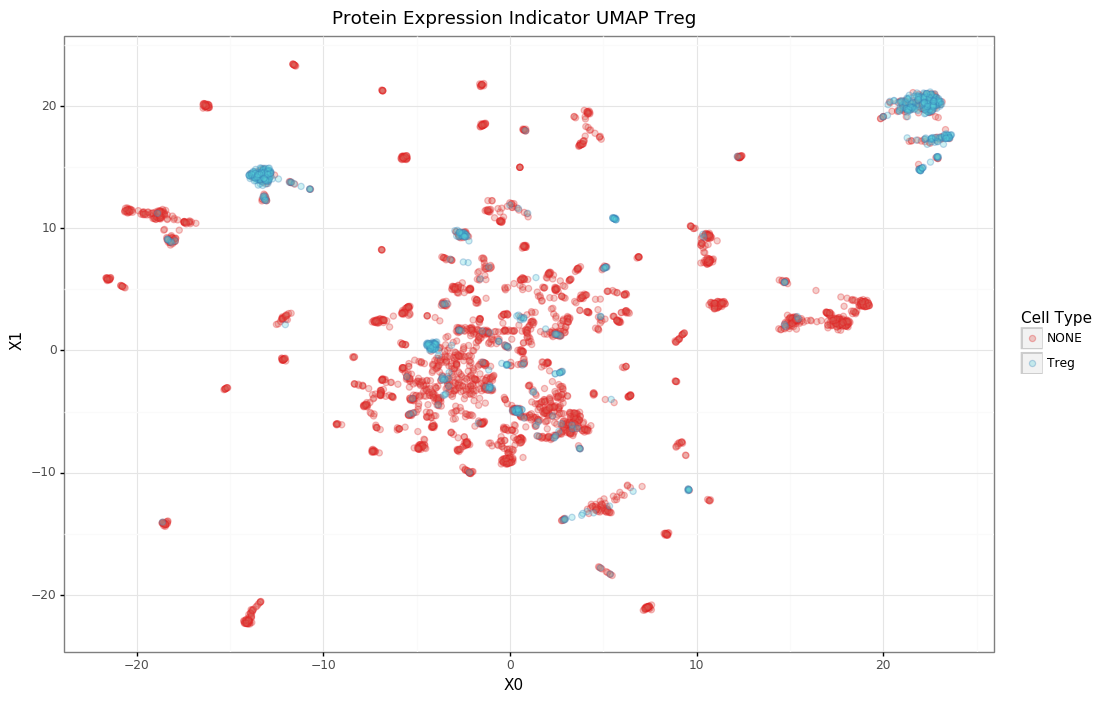

<ggplot: (-9223363260091397267)>

In [711]:
visualize_pair('Treg', 'NONE')

In [707]:
traces = []

for k, g in df_umap.reset_index().groupby('match_lbl'):
    traces.append(go.Scatter(
        x=g['X0'],
        y=g['X1'],
        text=[
            'Cell Type: {}<br>Prs: {}<br>Text: {}<br>RowID: {}<br>DocID: {}'.format(
                g['match_lbl'].iloc[i], g['pr_list'].iloc[i], 
                g['text'].iloc[i], g['row_id'].iloc[i],
                g['doc_id'].iloc[i]
            ) 
            for i in range(len(g))
        ],
        marker=dict(line=dict(width=0)),
        mode='markers',
        name=k
    ))
layout = go.Layout(hovermode='closest')
fig = go.Figure(data=traces, layout=layout)
plotly.offline.iplot(fig) 
# When ready: 
# plotly.tools.set_credentials_file(username='eczech', api_key='#####')
# py.iplot(fig, filename='protein_expression_umap_v1')

Examples within clusters:

- CD4+CD45RO+CXCR5+ **Tfh** cells [[PMC5519210]()]
    - neighbors:
        - CXCR5+ expressing CD4+CD45RO+ T cells [[PMC4504540]()]
        - memory (CD45RO+) CXCR5+CD4+ T cells [[PMC6409398]()]
        - CXCR5hiBTLAhiCD4+ T cells [[PMC4972135]()]
- VP1-specific CD69+/CD103+ tissue-resident memory (**TRM**) cells [[PMC5056763]()]
    - neighbors:
        - human CD69+CD103+ CD8 T cells [[PMC5461007]()]
        - SIINFEKL-specific tetramer-binding resident memory-like CD103+CD69+CXCR3+ CD8 T cells [[PMC5173246]()]
        - intrahepatic CD45RA−CD69+CD103+ CD8 T cells [[PMC5461007]()]
- Tscm CD4+CD45RA+CD45RO−CD62L+CCR7+CD127+CD27+CD28+CD95+CD122+ T (**Tscm**) cell [[PMC4902324]()]
    - neighbors:
        - CD4+CD45RA+CD45RO–CD62L+CCR7+CD127+CD27+CD28+CD95+CD122+T-Cell Subsets [[PMC4902324]()]
        - CD4+CD45RA+CD45RO−CD62L+CCR7+CD127+CD27+CD28+CD95+CD122+ T cells [[PMC4902324]()]
- **Th2** (IL-4+ IFN-γ−) cells [[PMC2212016]()]
    - neighbors:
        - IFN-γ–IL-4+CD4+ T cells [[PMC3767795]()]
        - IL-4+IFN-γ− NKT2 cells [[PMC2193332]()]
        - IL-4/IFN-γ-producing T cells [[PMC4718521]()]

In [493]:
df_viz[df_viz['row_id'] == 17437]

doc_id  end_wrd  match_ct match_lbl               pr_id  \
29041  PMC4515297     4553         0      None  CK216B03A5814616B8   
29042  PMC4515297     4553         0      None           PR:Q12918   
29043  PMC4515297     4553         0      None  CK16DDDB94C109D0EA   

                                                              pr_lbl  \
29041                                                            CD4   
29042  killer cell lectin-like receptor subfamily B member 1 (human)   
29043                                                           CCR6   

                pr_prefid pr_preflbl  pr_sign pr_typ  row_id  start_wrd  \
29041  CK216B03A5814616B8        CD4        1     ck   17437       4549   
29042           PR:Q12918      CD161        1     pr   17437       4549   
29043  CKFD0F253EB33B13FE       CCR6        1     ck   17437       4549   

                           text  
29041  CD4+CD161+CD196+ T cells  
29042  CD4+CD161+CD196+ T cells  
29043  CD4+CD161+CD196+ T cells